In [1]:
%matplotlib notebook
import numpy as np
import os
from matplotlib import pyplot as plt
from poseutils.constants import *
from model_opr import load_model
import sys
import torch
import ijson
from math import sqrt
from tqdm import tqdm
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from draw_figure import Draw3DSkeleton
import matplotlib.gridspec as gridspec
from dataloader import val_loader
from PIL import Image

# from torchvision.io import read_image

### Print out essential informaiton for GPA dataset

In [2]:
print(NAMES_16)
idx_dataset_gpa, sorted_idx_gpa = dataset_indices("gpa", 16)
# idx_dataset, sorted_idx = dataset_indices("h36m", 16)
print(idx_dataset_gpa)
print(sorted_idx_gpa)

for i in range(16):
    print(f"{NAMES_16[i]}: {sorted_idx_gpa[i]}")


JOINT_CONNECTIONS = [[1, 0], [4, 0], [7, 0],
                     [2,1], [3,2],
                     [5,4], [6,5],
                     [17,7], [8,17],
                     [14,8], [11,8], [9,8], [10,9],
                     [15,14], [16,15],
                     [12,11], [13,12]]


JOINT_COLOR_INDEX = [0, 2, 1,
                     0, 0,
                     2, 2,
                     1, 1,
                     0, 2, 1, 1,
                     0, 0,
                     2, 2]

img_mean = np.array([123.675,116.280,103.530])
img_std = np.array([58.395,57.120,57.375])


path_to_json = "./GPA_dataset/xyz_gpa12_mdp_cntind_crop_cam_c2g.json"
path_to_imgs = "./GPA/Gaussian_cropped_images"
# include modules from different directory
sys.path.insert(1, "/home/feiyangm/human_pose_estimation/GPA_Utils/")
from conversion import convert_json_to_npz_world_cam

['Hip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'Spine', 'Neck', 'Head', 'LUpperArm', 'LElbow', 'LWrist', 'RUpperArm', 'RElbow', 'RWrist']
[0, 24, 25, 26, 29, 30, 31, 2, 5, 6, 7, 17, 18, 19, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
Hip: 0
RHip: 1
RKnee: 2
RAnkle: 3
LHip: 4
LKnee: 5
LAnkle: 6
Spine: 7
Neck: 8
Head: 10
LUpperArm: 11
LElbow: 12
LWrist: 13
RUpperArm: 14
RElbow: 15
RWrist: 16


### Create function to read data from GPA json file

In [3]:
def convert_json_to_npz(dataset_path, save_filename, predictions, total=None):
    # keys: ['id', 'image_id', 'joint_cams', 'joint_imgs', 'c', 'f', 'c_c', 'c_f', 'istrains', 'istests', 'is_c2g']
    # TODO: test this function

    data_id_train = []
    data_id_test = []
    data_id_c2g = []
    data_img_id_train = []
    data_img_id_test = []
    data_img_id_c2g = []
    data_joint_cams_train = []
    data_joint_cams_test = []
    data_joint_cams_c2g = []
    data_joint_imgs_train = []
    data_joint_imgs_test = []
    data_joint_imgs_c2g = []
    data_c_train = []
    data_c_test = []
    data_c_c2g = []
    data_f_train = []
    data_f_test = []
    data_f_c2g = []
    data_c_c_train = []
    data_c_c_test = []
    data_c_c_c2g = []
    data_c_f_train = []
    data_c_f_test = []
    data_c_f_c2g = []


    with open(dataset_path, 'r') as file:
        json_data = ijson.items(file, 'annotations.item')

        for entry in tqdm(json_data, total=total):
            id = entry['id']
            image_id = entry['image_id']
            # # shape becomes (34, 3)
            joint_cams = np.transpose(np.array(entry['joint_cams'], dtype=np.float32))
            # print(joint_cams)
            # break
            

            
            joint_imgs = np.array(entry['joint_imgs'], dtype=np.float32)
            
            c = np.array(entry['c'], dtype=np.float32)
            f = np.array(entry['f'], dtype=np.float32)
            c_c = np.array(entry['c_c'], dtype=np.float32)
            c_f = np.array(entry['c_f'], dtype=np.float32)

            if entry['istrains']:
                data_id_train.append(id)
                data_img_id_train.append(image_id)
                data_joint_cams_train.append(joint_cams)
                data_joint_imgs_train.append(joint_imgs)
                data_c_train.append(c)
                data_f_train.append(f)
                data_c_c_train.append(c_c)
                data_c_f_train.append(c_f)

            elif entry['istests']:
                data_id_test.append(id)
                data_img_id_test.append(image_id)
                data_joint_cams_test.append(joint_cams)
                data_joint_imgs_test.append(joint_imgs)
                data_c_test.append(c)
                data_f_test.append(f)
                data_c_c_test.append(c_c)
                data_c_f_test.append(c_f)
            
            elif entry['is_c2g']:
                data_id_c2g.append(id)
                data_img_id_c2g.append(image_id)
                data_joint_cams_c2g.append(joint_cams)
                data_joint_imgs_c2g.append(joint_imgs)
                data_c_c2g.append(c)
                data_f_c2g.append(f)
                data_c_c_c2g.append(c_c)
                data_c_f_c2g.append(c_f)

            # id 1
            # image_id 1
            # joint_cams 3 34
            # joint_imgs 34 [Decimal('142.7467803955078'), Decimal('122.59777069091797')]
            # c 2 970.0303499730985
            # f 2 1071.506958565541
            # c_c 2 454.6243422712787
            # c_f 2 596.075409157109
            # istrains True
            # istests False
            # is_c2g False

    file.close()

    print("c2g: ", len(data_joint_cams_c2g))
    print("test: ", len(data_joint_cams_test))
    print("train: ", len(data_joint_cams_train))


    data = {
        "istrains": {
            "id": data_id_train,
            "image_id": data_img_id_train,
            "joint_cams": data_joint_cams_train,
            "joint_imgs": data_joint_imgs_train,
            "c": data_c_train,
            "f": data_f_train,
            "c_c": data_c_c_train,
            "c_f": data_c_f_train,
        },
        "istests": {
            "id": data_id_test,
            "image_id": data_img_id_test,
            "joint_cams": data_joint_cams_test,
            "joint_imgs": data_joint_imgs_test,
            "c": data_c_test,
            "f": data_f_test,
            "c_c": data_c_c_test,
            "c_f": data_c_f_test,
        },
        "is_c2g": {
            "id": data_id_c2g,
            "image_id": data_img_id_c2g,
            "joint_cams": data_joint_cams_c2g,
            "joint_imgs": data_joint_imgs_c2g,
            "c": data_c_c2g,
            "f": data_f_c2g,
            "c_c": data_c_c_c2g,
            "c_f": data_c_f_c2g,
        }
    }

    # np.savez_compressed(save_filename, data=data)


### GPA class to allow users to pass data to dataloader

In [9]:
class GPA(Dataset):
    def __init__(self, path, transform=transforms.ToTensor()):

        self.base_path = path
        self.img_names = os.listdir(path)[:100]
        self.transform = transform

        # TODO: when calculating the mean, do we need to care about rgb values? will that impact the model
        # ordering of RGB values matters to how CNN understands the images

    

    def normalize(self, img, flag = True):
        if flag:
            img = img[:,:,[2,1,0]]
    
        return np.divide(img - img_mean, img_std)


    def __len__(self):
        return len(self.img_names)
        

    def __getitem__(self, index):
        file_name = self.img_names[index]
        file_path = os.path.join(self.base_path, file_name)

        # shape should be (256, 256, 3)
#         img = Image.open(file_path)
        
        img = plt.imread(file_path)

        # FIXME: RGB channel is correct but it causes some predictions to be infinity...
        # img_np = np.array(img)
        # print(img_np.shape)
        # plt.imshow(img_np)
        # plt.show()
        # print(type(img_np))

        # preprocess the imgs
        new_img = self.normalize(img)

        new_img = np.transpose(new_img, (2,0,1))

        img_fliped = new_img[:,:,::-1].copy()
        img_fliped = torch.from_numpy(img_fliped).float()
        
        new_img = torch.from_numpy(new_img).float()
        return new_img, img_fliped

### Load model and run with GPA dataset

In [10]:
# load data from json file and save it into a .p
# convert_json_to_npz(path_to_json, "./gpa_joints")
# joints_data = np.load("./gpa_joints.npz", allow_pickle=True)


# joints_data = joints_data['data']

# # FIXME: there is no data stored inside npz file
# print(joints_data.shape)

# ["istrain"]["joint_cams"]

# print(joints_data)


### Define validate function to calculate mean squared error (MSE) between predictions and actual joints coordinates

In [11]:
from config import config
from network import Network

# define network 
model = Network(config)
# device = torch.device('cpu')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# print(torch.cuda.current_device())
# print(torch.cuda.memory_summary(device=device, abbreviated=False))
torch.cuda.empty_cache()
model = model.to(device)

GPA_imgset = GPA(path_to_imgs)

dataloader = torch.utils.data.DataLoader(GPA_imgset, batch_size=1, shuffle=False)

# load model weights
load_model(model, "./ckpt/hemlets_h36m_lastest.pth", cpu=not torch.cuda.is_available())
model.eval()


model_path ./ckpt/hemlets_h36m_lastest.pth


Network(
  (backbone): ResNetBackbone(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [12]:
flip_pairs = np.array([[1, 4], [2, 5], [3, 6], [14, 11], [15, 12], [16, 13]], dtype=np.intc)


def from_normjoint_to_cropspace(joint3d):
    joint3d[:,:,:2] = (joint3d[:,:,:2] + 0.5 )*256.0
    return joint3d


def eval_metric(pred_joint3d_numpy, pred_joint3d_filp_numpy):
    
    pred_joint3d_numpy_crop = from_normjoint_to_cropspace(pred_joint3d_numpy)
    # gt_joint3d_numpy_crop = from_normjoint_to_cropspace(gt_joint3d_numpy)
    pred_filp_joint3d_numpy_crop = from_normjoint_to_cropspace(pred_joint3d_filp_numpy)

    patch_width = 256.0

    for i in range(pred_joint3d_numpy.shape[0]):
        crop_pred_j3d = pred_joint3d_numpy_crop[i]
        pipws_flip = pred_filp_joint3d_numpy_crop[i]
        pipws_flip[ :, 0] = patch_width - pipws_flip[ :, 0] - 1
        for pair in flip_pairs:
            tmp = pipws_flip[ pair[0], :].copy()
            pipws_flip[ pair[0], :] = pipws_flip[ pair[1], :].copy()
            pipws_flip[ pair[1], :] = tmp.copy()

        # blending flip 3D joints
        mixJoint = (pipws_flip + crop_pred_j3d) * 0.5

        mixJoint[:,2]*=128
        return mixJoint

<IPython.core.display.Javascript object>


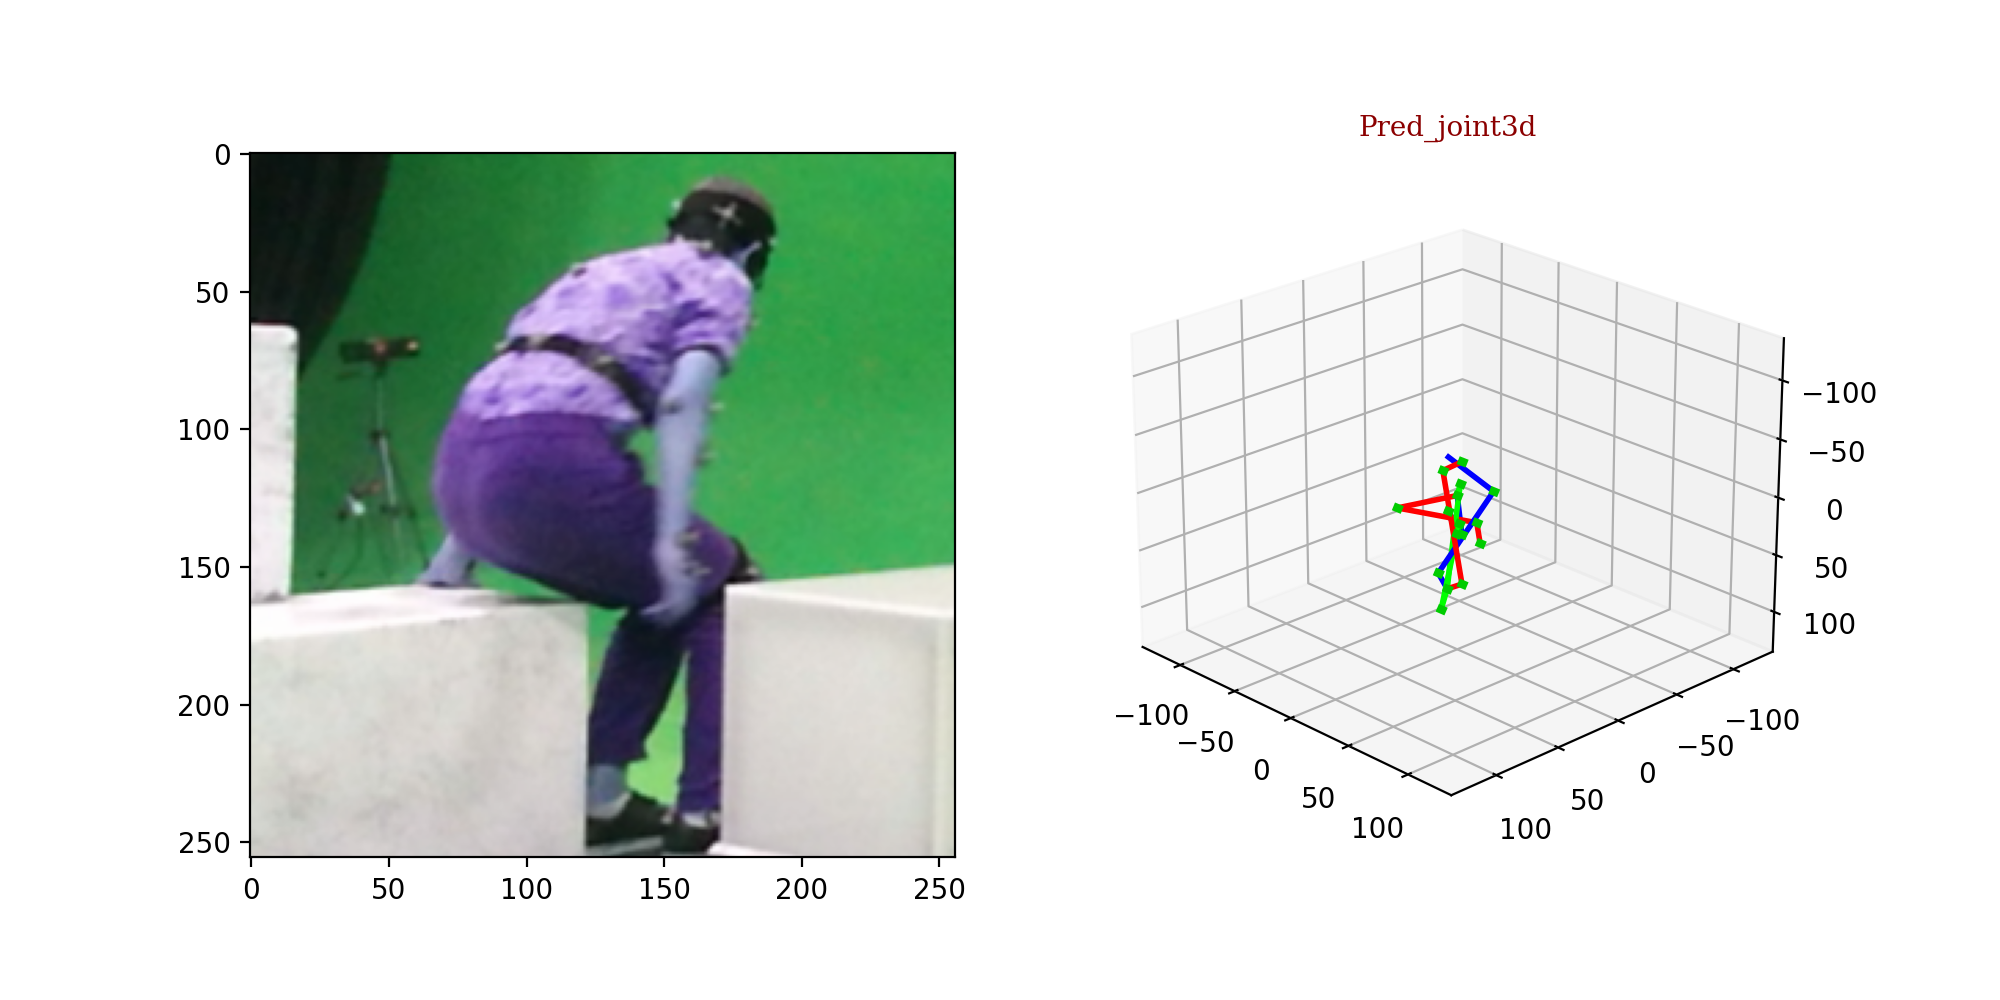

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [13]:
index = 0

font = {
    'family' : 'serif',  
    'color'  : 'darkred',  
    'weight' : 'normal',  
    'size'   : 10,  
}

fig = plt.figure( figsize=(10, 5) )
# gs1 = gridspec.GridSpec(2, 3) # 6 rows, 10 columns
# gs1.update(left=0.08, right=0.98,top=0.95,bottom=0.08,wspace=0.05, hspace=0.1)
axPose3d_pred=fig.add_subplot(122, projection='3d')
bx = fig.add_subplot(121)
plt.ion()
plt.show()

predictions = []

for img, img_fliped in dataloader:

    bx.imshow(img[0].permute(1, 2, 0).numpy()*img_std + img_mean, vmin=0, vmax=1)
    
    # convert to torch.cuda.FloatTensor
    with torch.no_grad():
        img, img_fliped = img.to(device), img_fliped.to(device)

    # # predict joint coordinates
    pred_joint3d, pred_joint3d_fliped = model(img, val=True), model(img_fliped, val=True)

    # # joints_3d = np.squeeze(pred_joint3d.detach().cpu().numpy(), axis=0)
    # # ax = plt.figure().add_subplot(111, projection='3d')
    pred_joint3d_ndarray, pred_joint3d_fliped_ndarray = pred_joint3d.detach().cpu().numpy(), pred_joint3d_fliped.detach().cpu().numpy()

    mixJoint = eval_metric(pred_joint3d_ndarray.copy(), pred_joint3d_fliped_ndarray.copy())

    Draw3DSkeleton(mixJoint, axPose3d_pred, JOINT_CONNECTIONS, 'Pred_joint3d', fontdict=font, j18_color=JOINT_COLOR_INDEX, image=None)

    # TODO: convert result to camera coordinates

    # ['Hip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'Spine', 'Neck', 'Head', 'LUpperArm', 'LElbow', 'LWrist', 'RUpperArm', 'RElbow', 'RWrist']
    # [0, 24, 25, 26, 29, 30, 31, 2, 5, 6, 7, 17, 18, 19, 9, 10, 11]
    # [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]

    point = pred_joint3d_ndarray[0]
    predictions.append(point)
    
    break

    # ratio: 51 / 460
    

    # print(point)

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.0001)

    axPose3d_pred.clear()
    axPose3d_pred.set_xlim((-128, 128))
    axPose3d_pred.set_ylim((-128, 128))
    axPose3d_pred.set_zlim((-128, 128))
    
    bx.clear()
    # fig.clear()


### Check error based on first image

In [21]:
def normalized_to_original(image):
    image_numpy = image.cpu().numpy()
    image_numpy = np.transpose(image_numpy, (0, 2, 3, 1))
    image_numpy = image_numpy * img_std + img_mean
    return image_numpy.astype(np.uint8)


def evaluate_one_image(predicts: list, actuals: list):
    # [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]

    mse = []
    for i in range(len(actuals)):
        pred_relative = predicts[i] - predicts[0]
        actual_relative =  actuals[i] - actuals[0]
        error = np.sqrt(np.sum(np.square(pred_relative - actual_relative)))
        mse.append(error)

    return np.mean(mse)


def from_normjoint_to_cropspace(joint3d):
    joint3d[:,:,:2] = (joint3d[:,:,:2] + 0.5 )*256.0
    return joint3d

In [24]:
joints_errors = 0.0

print(np.isnan(predictions).any())
print(np.isfinite(predictions).any())
print(np.isneginf(predictions).any())

with open(path_to_json, 'r') as file:
    json_data = ijson.items(file, 'annotations.item')

    num = 0
    for entry in tqdm(json_data, total=None):
        if num > 100:
            break
        # id = entry['id']
        # image_id = entry['image_id']
        # # shape becomes (34, 3)
        joint_cams = np.transpose(np.array(entry['joint_cams'], dtype=np.float32))[np.array(idx_dataset_gpa)]

        # process z axis direction
        joint_cams[:,2] = joint_cams[:,2] / 255.0 - 0.5
        joint_cams[:,0:2] = joint_cams[:,0:2] / 256.0 - 0.5

        # print(joint_cams)
        # print(joint_cams.shape)
        # print(predictions[0].shape)
        # assert(predictions[0].shape == joint_cams.shape)
        
        # print(predictions.shape)
        new_predictions = from_normjoint_to_cropspace(predictions[0][np.newaxis, :, :])
        joint_cams = from_normjoint_to_cropspace(joint_cams[np.newaxis, :, :])

    
        # print(new_predictions[0].shape)
        
        # print("prediction: ", new_predictions)
        # print("actuals normalized: ", joint_cams)


        mse = evaluate_one_image(new_predictions[0], joint_cams[0])
        joints_errors += mse
        num += 1


mse_errors_joint = joints_errors / 100
print(mse_errors_joint)


0it [00:00, ?it/s]

True
False


/tmp/ipykernel_2865878/2998399400.py:13: RuntimeWarning: invalid value encountered in subtract
  pred_relative = predicts[i] - predicts[0]
72it [00:00, 89.32it/s]

nan
